In [1]:
# Load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
import tensorflow as tf

## **Retrieve the dataset**

In [2]:
#Dataset informations
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']

#Retrieve online csv file
train_path = tf.keras.utils.get_file(
    "iris_training_csv",
    "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
)

test_path = tf.keras.utils.get_file(
    "iris_test_csv",
    "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"
)

#Retrieve the training and testing dataset
df_train = pd.read_csv(train_path, names= CSV_COLUMN_NAMES, header= 0)
df_test  = pd.read_csv(test_path, names= CSV_COLUMN_NAMES, header= 0)

df_train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


##**Exploratory Data Analysis**

In [3]:
#Analysis dataset dimension
df_train.shape

(120, 5)

In [4]:
#Analysis dataset statistics
df_train.describe()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
count,120.000000,120.000000,120.000000,120.000000,120.000000
mean,5.845000,3.065000,3.739167,1.196667,1.000000
std,0.868578,0.427156,1.822100,0.782039,0.840168
min,4.400000,2.000000,1.000000,0.100000,0.000000
25%,5.075000,2.800000,1.500000,0.300000,0.000000
50%,5.800000,3.000000,4.400000,1.300000,1.000000
75%,6.425000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [5]:
# Retrieve the feature data types
df_train.dtypes

SepalLength    float64
SepalWidth     float64
PetalLength    float64
PetalWidth     float64
Species          int64
dtype: object

In [6]:
#Check missing data
missing_values = df_train.isna()
((df_train[missing_values].sum(axis=0) / df_train.shape[0])*100).round(1).astype(str) +"%"

SepalLength    0.0%
SepalWidth     0.0%
PetalLength    0.0%
PetalWidth     0.0%
Species        0.0%
dtype: object

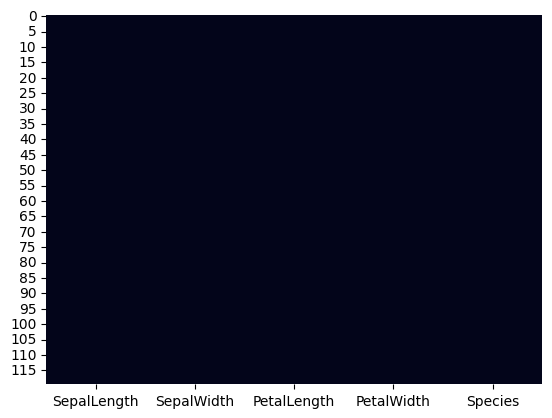

In [7]:
#Retrieve and print an image representation of the missing values
plt.figure()
sns.heatmap(missing_values, cbar= False)
plt.show()

In [8]:
#Separate the the features and target
X_train = df_train.drop("Species", axis = 1) #Training dataset features (Dataframe)
y_train = df_train["Species"] #Training dataset labeled (Series)

X_test = df_test.drop("Species", axis = 1) #Testing dataset features (Dataframe)
y_test = df_test["Species"] #Testing dataset labeled (Series)

print(X_train.head())
print()
print(y_train.head())

   SepalLength  SepalWidth  PetalLength  PetalWidth
0          6.4         2.8          5.6         2.2
1          5.0         2.3          3.3         1.0
2          4.9         2.5          4.5         1.7
3          4.9         3.1          1.5         0.1
4          5.7         3.8          1.7         0.3

0    2
1    1
2    2
3    0
4    0
Name: Species, dtype: int64


In [9]:
#Analysis the labeled distribution.
print(y_train.value_counts())
print(y_test.value_counts())

Species
2    42
0    42
1    36
Name: count, dtype: int64
Species
1    14
2     8
0     8
Name: count, dtype: int64


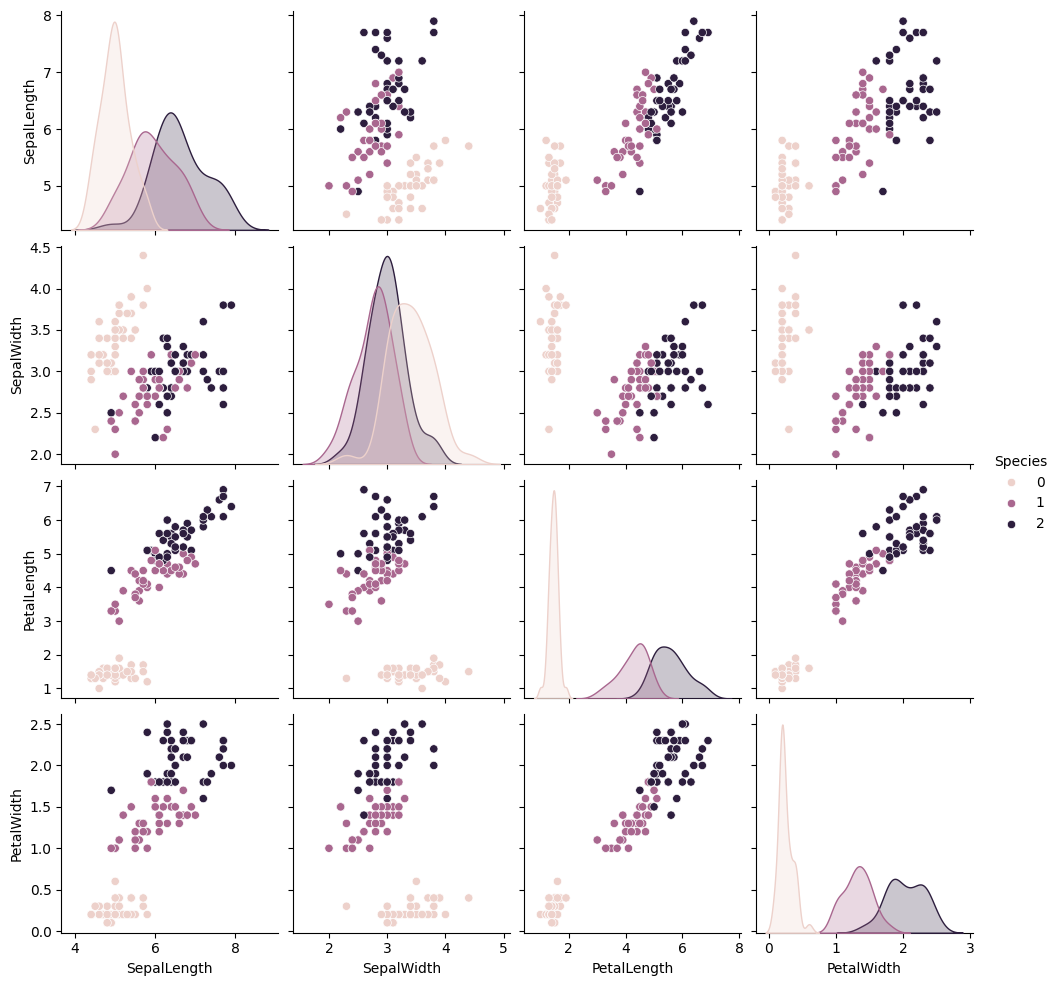

In [10]:
#Plot the distribution
sns.pairplot(df_train, hue="Species", diag_kind='kde')

Clear separation hyperplane can be seen between the various species, so the Support Vector Classifier or DNN Classifier could be a good model for this dataset.

##**Preprocessing**

In [11]:
#Create preprocessing function
def preprocessing(X: pd.DataFrame) -> dict:
  #Copy of the features to encode and scale.
  X_res = pd.DataFrame()

  # Scale numerical features.
  for col in X.columns:
    mean = X[col].mean()
    var = X[col].var()

    layer = tf.keras.layers.Normalization(
        axis=None, mean= mean, variance= var,
        )
    X_res[col] = layer(X[col])

  return X_res

In [12]:
#Test the preprocessing function
preprocessing(X_train)

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,0.638975,-0.620383,1.021257,1.282971
1,-0.972854,-1.790915,-0.241022,-0.251479
2,-1.087984,-1.322702,0.417558,0.643616
3,-1.087984,0.081937,-1.228893,-1.402317
4,-0.166939,1.720683,-1.119130,-1.146575
...,...,...,...,...
115,-0.397200,-1.088596,0.362677,0.004262
116,-0.166939,-0.152169,0.252913,0.004262
117,-1.663637,-0.386276,-1.283775,-1.274446
118,-1.203115,-0.152169,-1.283775,-1.402317


In [13]:
#Encode and scale the actual datasets
X_train = preprocessing(X_train)
X_test  = preprocessing(X_test)

X_test.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,0.096895,-0.021580,0.236321,0.422199
1,1.626817,0.194223,1.016829,1.285787
2,-1.127042,0.625832,-1.389738,-1.017115
3,0.249887,0.841636,0.431448,0.566130
4,-0.515073,-1.100601,0.106236,0.134336


##**Models**

In [14]:
#Create Support Vector Classifier model using GridSearchCV
svc_model = SVC(random_state=0)
parameters = {
    "C": [1, 10, 100],
    "kernel": ("linear", "poly", "rbf", "sigmoid"),
    "degree": np.arange(1, 6, 1)
}

grid_svc_model = GridSearchCV(
  estimator= svc_model,
  param_grid= parameters,
  scoring= "accuracy",
  cv= 5,
)

grid_svc_model

GridSearchCV(cv=5, estimator=SVC(random_state=0),
             param_grid={'C': [1, 10, 100], 'degree': array([1, 2, 3, 4, 5]),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             scoring='accuracy')

In [15]:
#Train the SVC model to find the optimised hyper-parameters
grid_svc_model.fit(X_train, y_train)
grid_svc_model.best_params_

{'C': 1, 'degree': 1, 'kernel': 'linear'}

In [16]:
#Retrieve the optimised SVC model
models = {"optimised_svc_model" : grid_svc_model.best_estimator_}

In [24]:
#Define an evaluation function for classification
def evaluation(models):
    for name, model in models.items():

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        print(model)

        N, train_scores, val_scores = learning_curve(estimator= model,
                                                    X= X_train,
                                                    y= y_train,
                                                    train_sizes= np.linspace(0.1, 1, 10),
                                                    cv =5,
                                                    scoring="accuracy",
                                                    )
        plt.figure(figsize=(12,8))
        plt.title(name)
        plt.plot(N, train_scores.mean(axis=1), c="orange", label= "Training score")
        plt.plot(N, val_scores.mean(axis=1), c="blue", label= "Validation score")
        plt.legend()
        plt.show()

        print(classification_report(y_test, y_pred))

SVC(C=1, degree=1, kernel='linear', random_state=0)


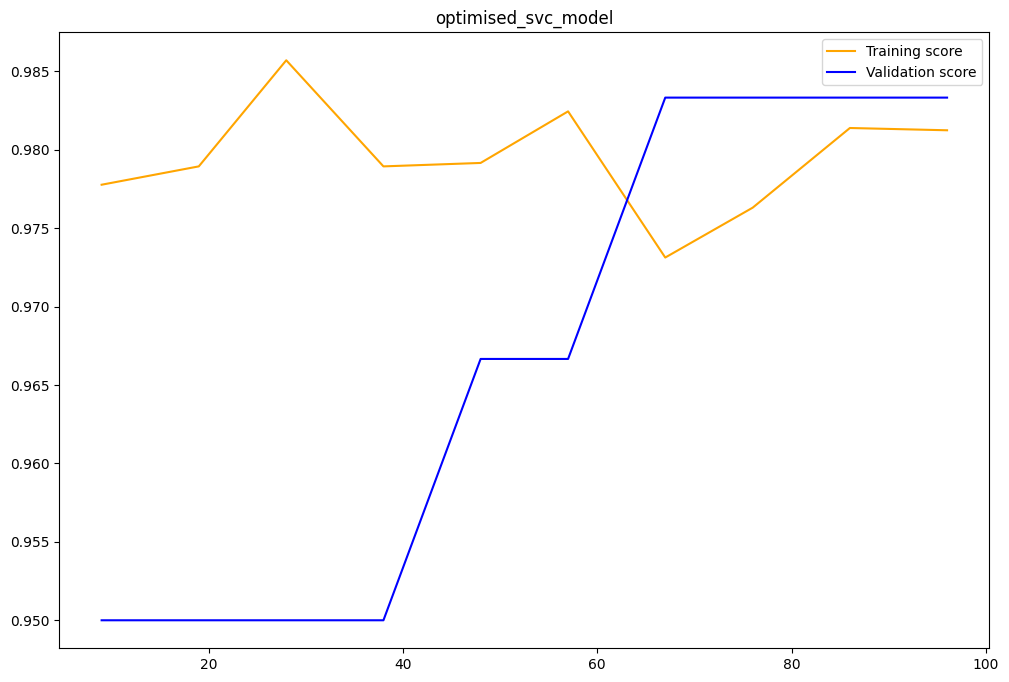

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      0.93      0.96        14
           2       0.89      1.00      0.94         8

    accuracy                           0.97        30
   macro avg       0.96      0.98      0.97        30
weighted avg       0.97      0.97      0.97        30



In [25]:
#Print the optimised SVC model prediction result
evaluation(models)

In [19]:
#Create Deep Neural Network Classifier model
dnn_model = tf.keras.Sequential(
    [
      tf.keras.layers.InputLayer(input_shape= X_train.shape[-1]),
      tf.keras.layers.Dense(units= 32, activation="relu"),
      tf.keras.layers.Dense(units= 32, activation="relu"),
      tf.keras.layers.Dense(units= 10),
    ]
)

# Indicate the model loss function, learning_rate and metrics
dnn_model.compile(
    optimizer=  "adam",
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
    metrics= ["accuracy"],
)

In [20]:
#Train the Deep Neural Network Classifier model
history = dnn_model.fit(
    x= X_train,
    y= y_train,
    epochs = 10,
    verbose= 0, #Suppress logging.
    validation_split= 0.2, #Optimise the hyperparameters with 20% of the training dataset.

)

In [21]:
#Add epoches
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
5,1.887746,0.697917,1.819423,0.666667,5
6,1.810633,0.708333,1.744417,0.666667,6
7,1.733569,0.708333,1.670182,0.666667,7
8,1.659741,0.708333,1.595356,0.666667,8
9,1.584589,0.708333,1.520953,0.666667,9


In [27]:
# Define an evaluation function for regression
def plot_loss(history):
  plt.plot(history.history['accuracy'], label='Training Accuracy', c="orange")
  plt.plot(history.history['val_accuracy'], label='Valisation Accuracy', c="blue")
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel("Accuracy")
  plt.legend()
  plt.grid(True)


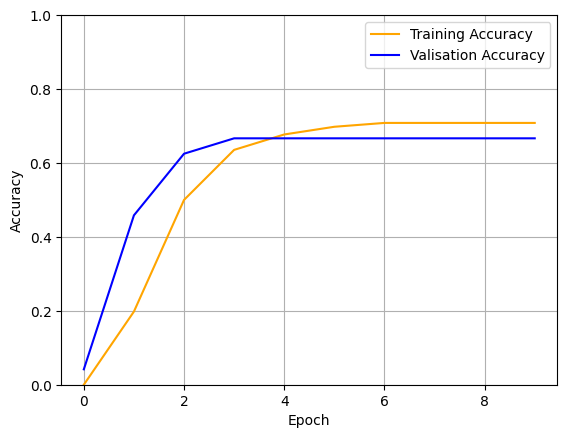

In [28]:
#Print the Deep Neural Network evaluation
plot_loss(history)

In [29]:
#Test the Deep Neural Network
test_loss, test_acc = dnn_model.evaluate(X_test,  y_test, verbose=2)
print(f"Test Accuracy: {test_acc}")

1/1 - 0s - loss: 1.6247 - accuracy: 0.5333 - 23ms/epoch - 23ms/step
Test Accuracy: 0.5333333611488342


## **Conclusion**




**The SVC model (97%) have better result then the deep learning model (53%), which contain a little overfitting.**